# Wildlife Citizen Science Data Visualization

This notebook generates comprehensive visualizations and maps for the Córdoba wildlife citizen science projects CONCIENCIADOS .

**Data sources:**
- GBIF occurrence records
- Camera trap data
- UTM grid cells (10x10 km)
- Citizen science platforms (validated and non-validated)

### Summary of Analyses and Visualizations


This notebook provides a comprehensive exploration of wildlife citizen science data from Córdoba province, integrating multiple data sources and spatial layers. The main analyses and visualizations include:


**1. Data Import and Preparation**
- Loading citizen science records, camera trap data, UTM grid shapefiles, and GBIF records.
- Cleaning and transforming data for spatial and statistical analysis.

**2. Distribution Analysis**
- Histograms of record counts for Sequences and Daily Record sources, revealing data skewness and reporting patterns.

**3. Correlation Analysis**
- Scatter plots and Pearson correlation between daily and sequence records by species, including outlier handling and annotation.
- Comparison of correlation with and without the most abundant species (O. cuniculus).

**4. Species Richness by Data Source**
- Bar plots showing the number of unique species detected by each platform (GBIF, No Validation, Sequences Record, Daily Record).

**5. Records by Species and Grid**
- Faceted bar plots visualizing the distribution of records for top species across the most sampled UTM grids.

**6. Temporal Trends**
- Line plots of record accumulation over time, grouped by taxonomic order and data source (if year/order data available).

**7. Spatial Visualizations**
- Interactive cluster maps of GBIF records by UTM grid, with popups showing species and source information.
- Heat maps of species occurrences and camera trap locations, overlaid with UTM grids.
- Multi-panel heatmaps for individual species using kernel density estimation.

**8. Statistical Modeling**
- Mixed-effects models to assess the influence of data source and spatial grid on record counts.
- Visualization of log-transformed record distributions by platform using violin and strip plots.

**9. Summary Reporting**
- Automated summary of generated images, interactive maps, and key dataset statistics.

---

**Overall, this notebook enables a multi-faceted understanding of biodiversity patterns, observer behavior, and spatial coverage in the region, supporting both ecological research and citizen science program evaluation.**

## 1. Import Libraries

In [81]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import folium
from folium.plugins import MarkerCluster, HeatMap
import webbrowser
from adjustText import adjust_text
import contextily as ctx
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Set style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 100

# Detect base directory
base_dir = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(base_dir, "data")
IMG_DIR = os.path.join(base_dir, "img")
HTML_DIR = os.path.join(base_dir, "html")

# Create directories if they don't exist
os.makedirs(IMG_DIR, exist_ok=True)
os.makedirs(HTML_DIR, exist_ok=True)

print(f"Data directory: {DATA_DIR}")
print(f"Images will be saved to: {IMG_DIR}")
print(f"HTML maps will be saved to: {HTML_DIR}")

Data directory: c:\Users\JoseAntonio.Blanco\OneDrive - Universidad de Castilla-La Mancha\Documentos\GitHub\Citizen_Science\data
Images will be saved to: c:\Users\JoseAntonio.Blanco\OneDrive - Universidad de Castilla-La Mancha\Documentos\GitHub\Citizen_Science\img
HTML maps will be saved to: c:\Users\JoseAntonio.Blanco\OneDrive - Universidad de Castilla-La Mancha\Documentos\GitHub\Citizen_Science\html


## 2. Load Data

In [82]:
# Load citizen science records
df = pd.read_csv(os.path.join(DATA_DIR, 'dataset_CSsources_mod.csv'))

# Load spatial data
gbif_df = gpd.read_file(os.path.join(DATA_DIR, "GBIFdata_CO.shp"))
CO_UTM_df = gpd.read_file(os.path.join(DATA_DIR, "CO_UTM2.shp"))

# Load camera locations
cameras = pd.read_csv(os.path.join(DATA_DIR, 'locCam3.csv'), sep=';')
cameras.columns = cameras.columns.str.strip()

# Load species silhouettes URLs
urls_df = pd.read_csv(os.path.join(DATA_DIR, 'siluetas.csv'))

print(f"Records dataset shape: {df.shape}")
print(f"GBIF records: {len(gbif_df)}")
print(f"UTM grids: {len(CO_UTM_df)}")
print(f"Camera locations: {len(cameras)}")

df.head()

Records dataset shape: (704, 5)
GBIF records: 1236
UTM grids: 177
Camera locations: 57


,spp,Species.Name,Grid,Data.Source,Records
0,O_cuniculus,O. cuniculus,UG18,Global Biodiversity,5
1,O_cuniculus,O. cuniculus,UG18,No Validation,34
2,O_cuniculus,O. cuniculus,UG18,Sequences Record,129
3,O_cuniculus,O. cuniculus,UG18,Daily Record,48
4,L_granatensis,L. granatensis,UG18,Global Biodiversity,0


## 3. Data Preparation

In [83]:
# Extract coordinates from GBIF data
gbif_df["Longitude"] = gbif_df.geometry.x
gbif_df["Latitude"] = gbif_df.geometry.y

# Remove rows with null coordinates
gbif_clean = gbif_df.dropna(subset=['Latitude', 'Longitude'])

# Create GeoDataFrame for cameras
cameras_points = gpd.GeoDataFrame(
    cameras,
    geometry=[Point(xy) for xy in zip(cameras['Longitude'], cameras['Latitude'])],
    crs="EPSG:4326"
)

# Reproject to Web Mercator for better visualization
gbif_3857 = gbif_clean.to_crs("EPSG:3857")
CO_UTM_3857 = CO_UTM_df.to_crs("EPSG:3857")
cameras_3857 = cameras_points.to_crs("EPSG:3857")

print("Data prepared successfully!")
print(f"Clean GBIF records: {len(gbif_clean)}")

Data prepared successfully!
Clean GBIF records: 1235


## 4. Analysing GBIF records from Córdoba province

In [84]:
# Create base map centered on Córdoba
mapa = folium.Map(location=[37.6, -4.5], zoom_start=8)

# Add UTM grid layer
folium.GeoJson(
    CO_UTM_df.__geo_interface__,
    name="UTM Grid (10x10 km)",
    style_function=lambda x: {
        'color': 'purple',
        'weight': 2,
        'opacity': 0.3,
        'fillOpacity': 0.05
    }
).add_to(mapa)

# Color map for data sources
color_map = {
    "iMammalia": "orange",
    "iNaturalist": "green",
    "Observation": "blue",
}
# Spatial join: assign each GBIF point to its grid
gbif_gdf = gpd.GeoDataFrame(
    gbif_clean, 
    geometry=gpd.points_from_xy(gbif_clean.Longitude, gbif_clean.Latitude),
    crs=CO_UTM_df.crs
)
gbif_with_grid = gpd.sjoin(gbif_gdf, CO_UTM_df, how="left")

# Merge with species URLs if available
if 'genus' in gbif_with_grid.columns:
    gbif_with_grid = gbif_with_grid.merge(urls_df, on="genus", how="left")
# Create clusters by grid
clusters_by_grid = {}
for _, row in gbif_with_grid.iterrows():
    grid_id = row.get('CUADRICULA', 'Unknown')
    
    if grid_id not in clusters_by_grid:
        clusters_by_grid[grid_id] = MarkerCluster(name=f"Grid {grid_id}")
        clusters_by_grid[grid_id].add_to(mapa)
    
    # Get institution/source
    institution = row.get('institut_1', 'Unknown')
    icon_color = color_map.get(institution, 'gray')
    
    # Get species info
    genus = row.get('genus', 'Unknown')
    url = row.get('url', '')
    
    # Create popup
    popup_html = f"""
    <div style="font-family: Arial; font-size: 14px; width: 200px;">
        {f'<img src="{url}" width="64" height="64"><br>' if url else ''}
        <b>Genus:</b> {genus}<br>
        <b>Source:</b> {institution}<br>
        <b>Grid:</b> {grid_id}<br>
    </div>
    """
    
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=folium.Popup(popup_html, max_width=250),
        icon=folium.Icon(color=icon_color, icon='paw', prefix='fa')
    ).add_to(clusters_by_grid[grid_id])

# Add layer control
folium.LayerControl().add_to(mapa)

# Save map
map_path = os.path.join(HTML_DIR, "mapa_clusters_por_grid.html")
mapa.save(map_path)

print(f"✓ Interactive map saved to {map_path}")
print(f"  Total grids with data: {len(clusters_by_grid)}")

✓ Interactive map saved to c:\Users\JoseAntonio.Blanco\OneDrive - Universidad de Castilla-La Mancha\Documentos\GitHub\Citizen_Science\html\mapa_clusters_por_grid.html
  Total grids with data: 134


## 5. Heat maps separated by species

In [ ]:


# Convert to GeoDataFrame
geometry = gpd.points_from_xy(gbif_clean['Longitude'], gbif_clean['Latitude'])
gbif_gdf = gpd.GeoDataFrame(gbif_clean, geometry=geometry, crs="EPSG:4326")

# Reproject to Web Mercator
gbif_gdf = gbif_gdf.to_crs(epsg=3857)
utm_gdf = CO_UTM_df.to_crs(epsg=3857)

# List of unique genres
especies = gbif_gdf['genus'].dropna().unique()

# Configure dynamic panel
n = len(especies)
cols = 3
rows = (n // cols) + (1 if n % cols else 0)
fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 6*rows))
axes = axes.flatten()

# Create maps by species
for i, especie in enumerate(especies):
    ax = axes[i]
    df_especie = gbif_gdf[gbif_gdf['genus'] == especie]

    # Capa UTM
    utm_gdf.plot(ax=ax, facecolor='none', edgecolor='purple', alpha=0.2)

    # KDE for density (only if there are enough points)
    if len(df_especie) > 5:
        sns.kdeplot(
            x=df_especie.geometry.x,
            y=df_especie.geometry.y,
            fill=True,
            cmap="Reds",
            bw_adjust=0.5,
            ax=ax,
            alpha=0.6,
            levels=10
        )

    # Points
    df_especie.plot(ax=ax, markersize=5, color='blue', alpha=0.5)

    # Background with contextily
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    ax.set_title(f"Mapa de calor: {especie}")
    ax.set_axis_off()

# Remove empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig(os.path.join(IMG_DIR, "panel_mapps_heat.png"), dpi=300, bbox_inches='tight')
plt.show()





## 6. Temporal trends of GBIF records 

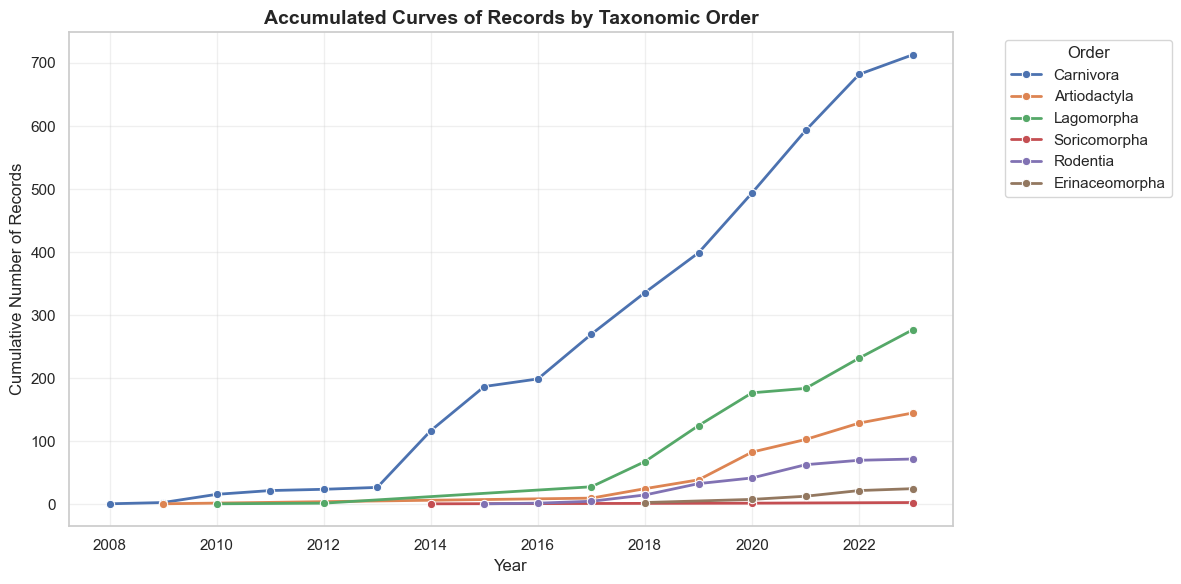

In [ ]:
# Check if 'year' column exists in GBIF data
if 'year' in gbif_clean.columns:
    # Group by year and taxonomic order
    if 'order' in gbif_clean.columns:
        temporal_order = gbif_clean.groupby(['year', 'order']).size().reset_index(name='n_records')
        
        # Compute cumulative records for each order
        temporal_order['cumulative_records'] = temporal_order.groupby('order')['n_records'].cumsum()
        
        # Plot accumulated curves
        plt.figure(figsize=(12, 6))
        sns.lineplot(data=temporal_order, x='year', y='cumulative_records', hue='order', marker='o', linewidth=2)
        plt.title('Accumulated Curves of Records by Taxonomic Order', fontsize=14, fontweight='bold')
        plt.xlabel('Year', fontsize=12)
        plt.ylabel('Cumulative Number of Records', fontsize=12)
        plt.legend(title='Order', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(IMG_DIR, 'accumulated_curves_orders.png'), dpi=300, bbox_inches='tight')
        plt.show()
        
    

## 7. Distribution Analysis: Histograms

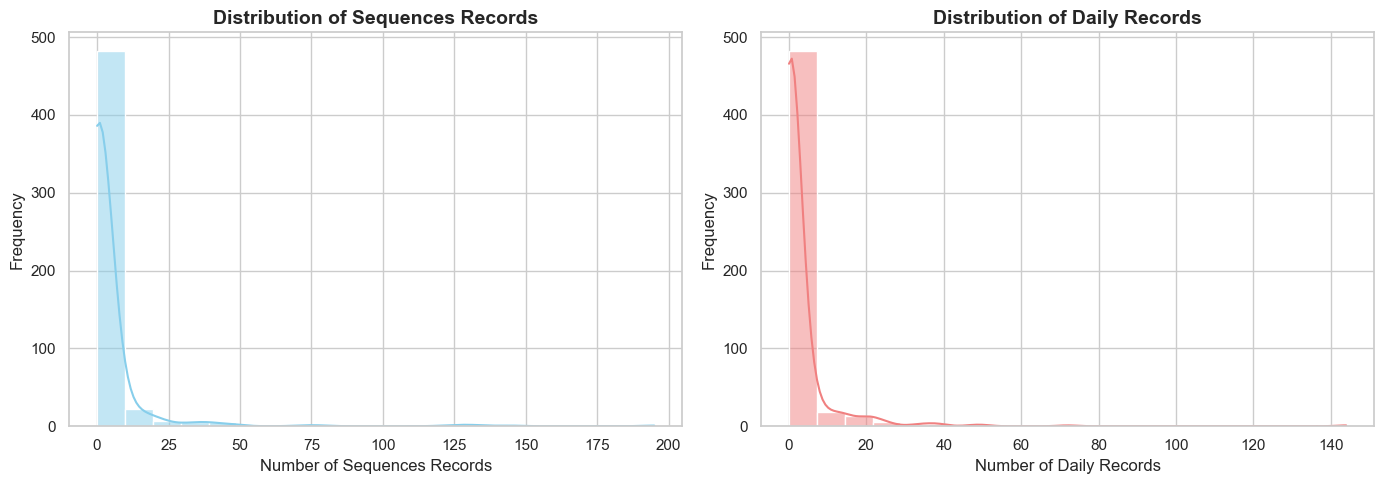

✓ Histogram saved to img/histogram_distributions.png


In [ ]:
# Separate data by source type
df_sequences = df[df['Data.Source'] != 'Daily Record']
df_daily = df[df['Data.Source'] != 'Sequences Record']

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram for Sequences Record
sns.histplot(df_sequences['Records'], bins=20, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Distribution of Sequences Records', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Sequences Records', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)

# Histogram for Daily Record
sns.histplot(df_daily['Records'], bins=20, kde=True, color='lightcoral', ax=axes[1])
axes[1].set_title('Distribution of Daily Records', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Daily Records', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(IMG_DIR, 'histogram_distributions.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Histogram saved to img/histogram_distributions.png")

In [ ]:
## 9. Species Richness by Data Source

In [ ]:
# Filter rows where the value is greater than zero
df_filtered = df[df['Records'] > 0]  

# Calculate richeness by data source
species_by_source = (
    df_filtered.groupby('Data.Source')['Species.Name']
    .nunique()
    .reset_index()
)

species_by_source.columns = ['Data Source', 'Number of Species']
print(species_by_source)

# Define colors
palette = {
    'Global Biodiversity': '#228B22',
    'No Validation': '#C71585',
    'Sequences Record': '#4169E1',
    'Daily Record': '#FFD700'
}

plt.figure(figsize=(10, 6))
bars = plt.bar(species_by_source['Data Source'], 
               species_by_source['Number of Species'],
               color=[palette.get(x, 'gray') for x in species_by_source['Data Source']])

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Species Richness by Data Source', fontsize=14, fontweight='bold')
plt.xlabel('Data Source', fontsize=12)
plt.ylabel('Number of Species', fontsize=12)
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(IMG_DIR, 'species_richness_by_source.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Species richness plot saved to img/species_richness_by_source.png")

## 9. Daily records Vs Sequences records

11 [-0.27233451 -0.24906163]
13 [ 0.67812884 -0.65799357]


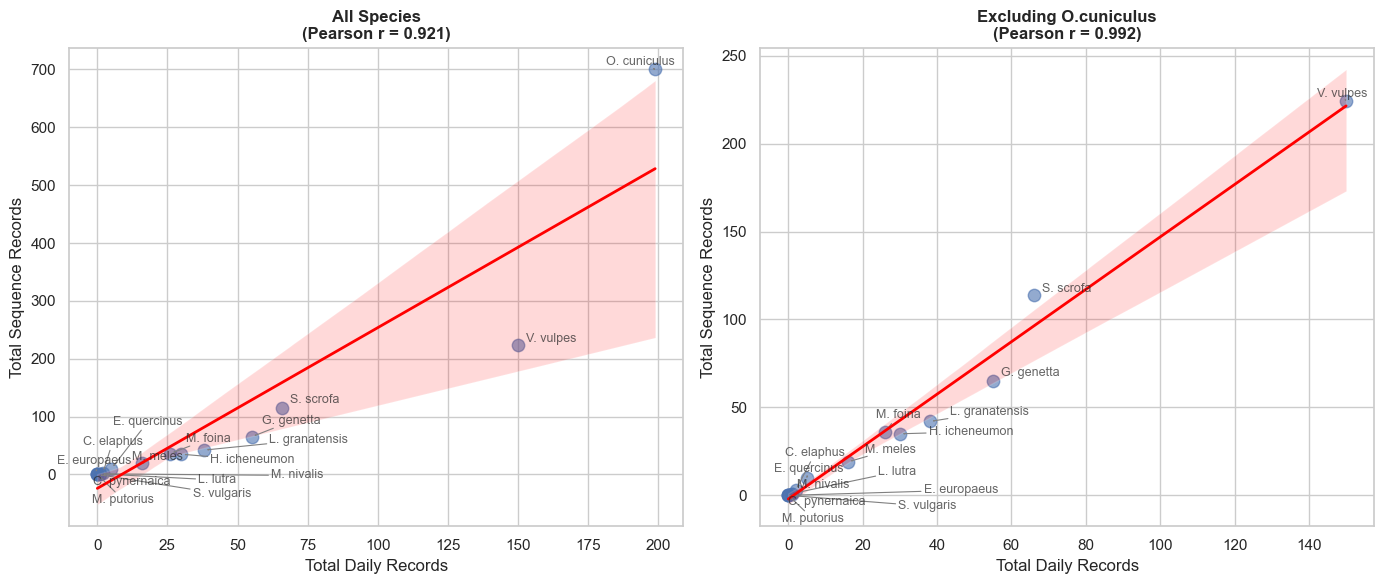

In [ ]:

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ---------------------- Plot 1: All species ----------------------
df_daily_agg = df[df['Data.Source'] == 'Daily Record'].groupby('Species.Name')['Records'].sum().reset_index()
df_daily_agg.rename(columns={'Records': 'Daily_Sum'}, inplace=True)

df_sequences_agg = df[df['Data.Source'] == 'Sequences Record'].groupby('Species.Name')['Records'].sum().reset_index()
df_sequences_agg.rename(columns={'Records': 'Sequences_Sum'}, inplace=True)

df_correlation_all = pd.merge(df_daily_agg, df_sequences_agg, on='Species.Name', how='outer').fillna(0)
corr_all = df_correlation_all[['Daily_Sum', 'Sequences_Sum']].corr(method='pearson').iloc[0, 1]

sns.regplot(x='Daily_Sum', y='Sequences_Sum', data=df_correlation_all,
            scatter_kws={'alpha': 0.6, 's': 80},
            line_kws={'color': 'red', 'linewidth': 2}, ax=axes[0])

texts_all = []
for idx, row in df_correlation_all.iterrows():
    texts_all.append(axes[0].text(row['Daily_Sum'], row['Sequences_Sum'], row['Species.Name'],
                                  fontsize=9, alpha=0.7))

adjust_text(texts_all, ax=axes[0], arrowprops=dict(arrowstyle='->', color='gray', lw=0.8))
axes[0].set_title(f'All Species\n(Pearson r = {corr_all:.3f})', fontsize=12, fontweight='bold')

# ---------------------- Plot 2: Excluding O.cuniculus ----------------------
df_no_oc = df[df['Species.Name'] != 'O. cuniculus']
df_daily_agg_no = df_no_oc[df_no_oc['Data.Source'] == 'Daily Record'].groupby('Species.Name')['Records'].sum().reset_index()
df_daily_agg_no.rename(columns={'Records': 'Daily_Sum'}, inplace=True)

df_sequences_agg_no = df_no_oc[df_no_oc['Data.Source'] == 'Sequences Record'].groupby('Species.Name')['Records'].sum().reset_index()
df_sequences_agg_no.rename(columns={'Records': 'Sequences_Sum'}, inplace=True)

df_correlation_no = pd.merge(df_daily_agg_no, df_sequences_agg_no, on='Species.Name', how='outer').fillna(0)
corr_no = df_correlation_no[['Daily_Sum', 'Sequences_Sum']].corr(method='pearson').iloc[0, 1]

sns.regplot(x='Daily_Sum', y='Sequences_Sum', data=df_correlation_no,
            scatter_kws={'alpha': 0.6, 's': 80},
            line_kws={'color': 'red', 'linewidth': 2}, ax=axes[1])

texts_no = []
for idx, row in df_correlation_no.iterrows():
    texts_no.append(axes[1].text(row['Daily_Sum'], row['Sequences_Sum'], row['Species.Name'],
                                 fontsize=9, alpha=0.7))

adjust_text(texts_no, ax=axes[1], arrowprops=dict(arrowstyle='->', color='gray', lw=0.8))
axes[1].set_title(f'Excluding O.cuniculus\n(Pearson r = {corr_no:.3f})', fontsize=12, fontweight='bold')

# Final layout
for ax in axes:
    ax.set_xlabel('Total Daily Records')
    ax.set_ylabel('Total Sequence Records')

plt.tight_layout()
plt.savefig('correlation_comparison.png', dpi=300)
plt.show()

In [ ]:
# 

## 10. Records by Species and Grid (Faceted Bar Plot)

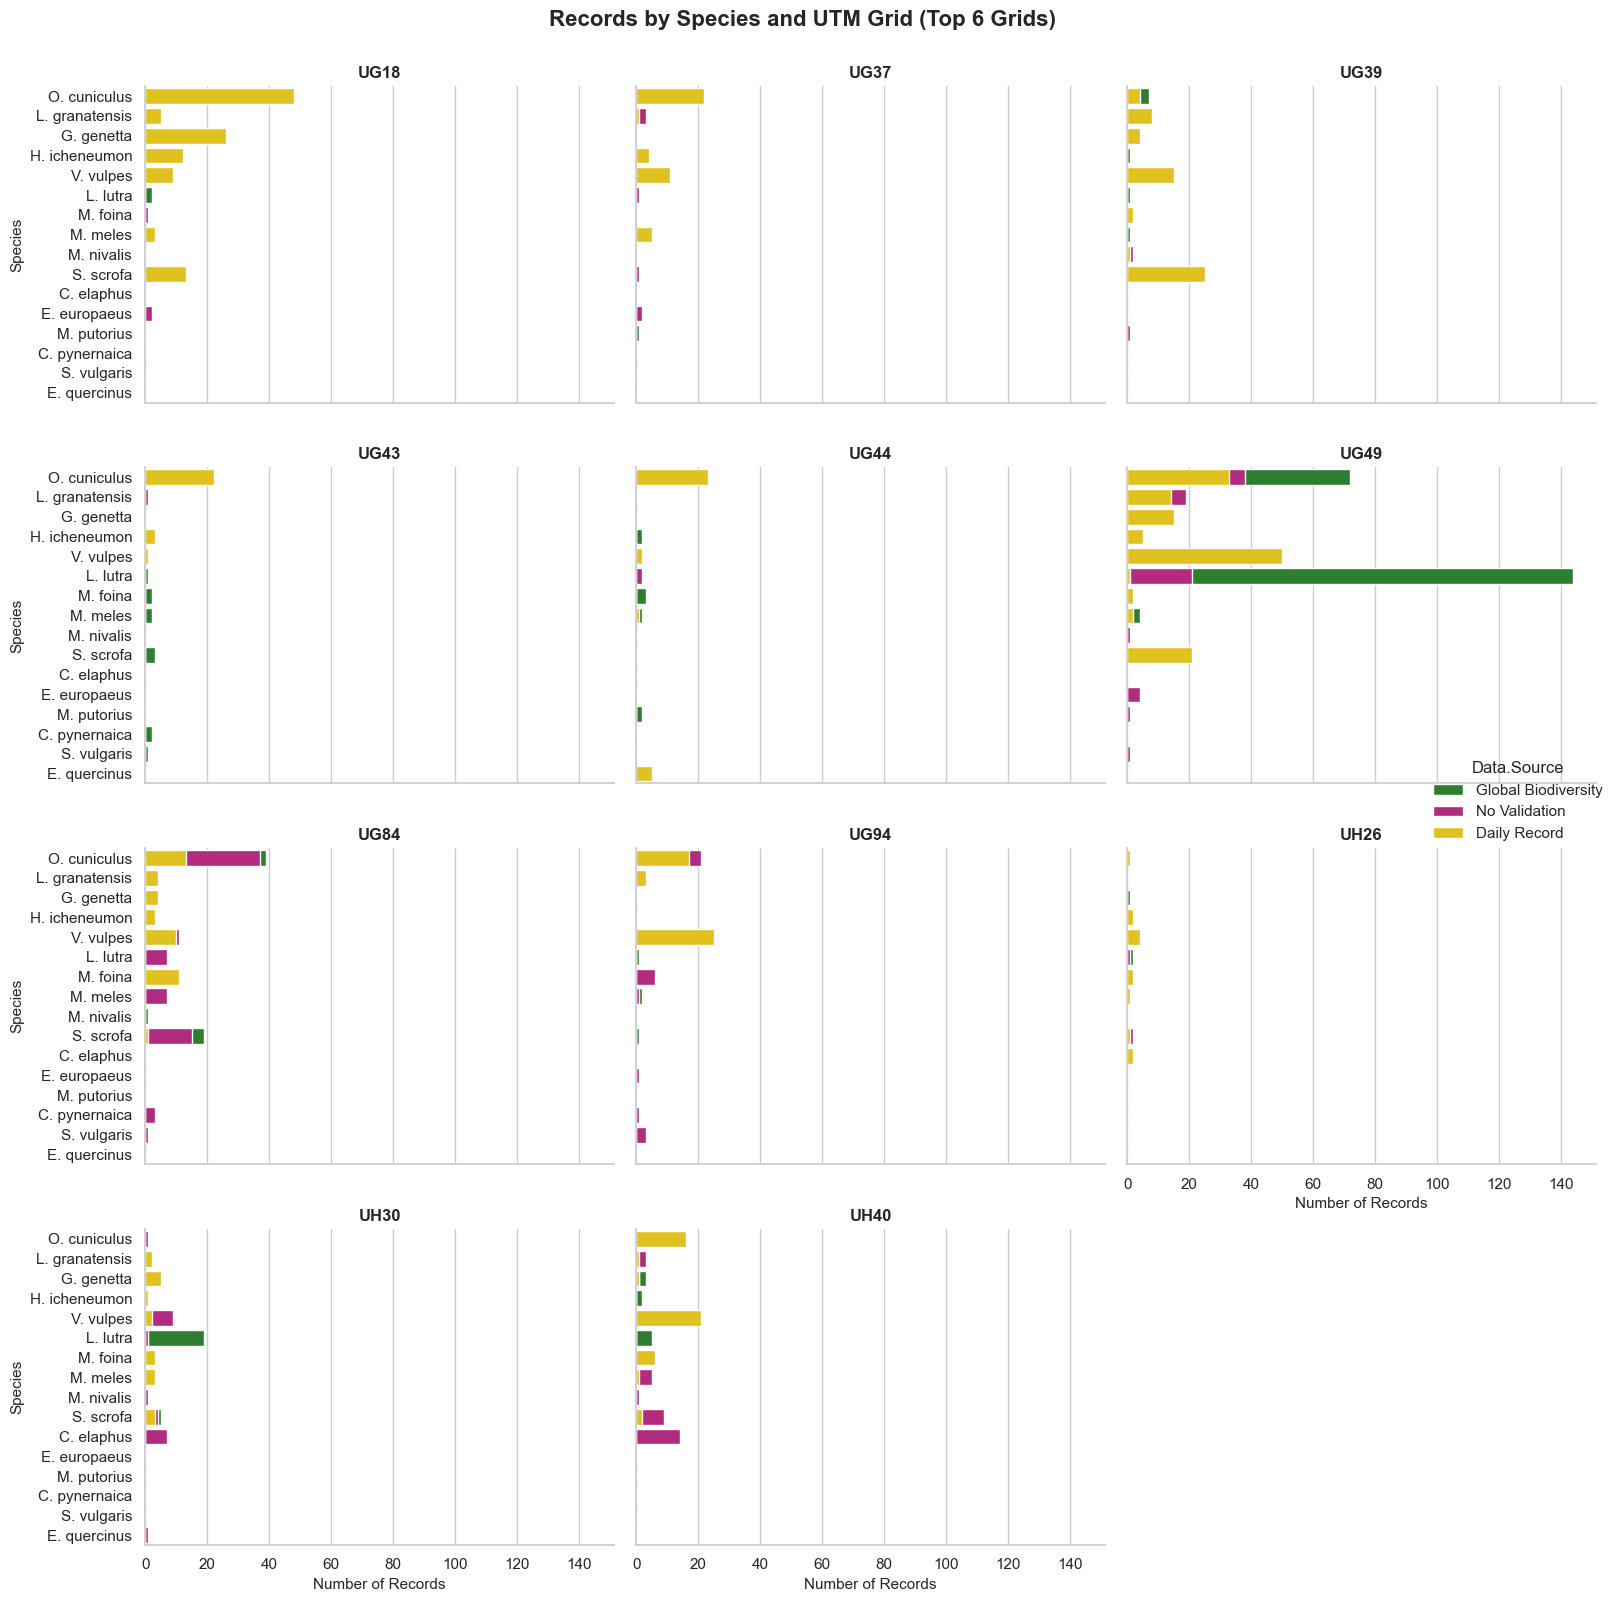

✓ Faceted plot saved to img/records_by_species_grid.png


In [ ]:
# Filter for analysis (exclude sequences for clearer visualization)
df_filtered = df[df['Data.Source'] != 'Sequences Record']

# Get top 6 grids by total records
top_grids = df_filtered.groupby('Grid')['Records'].sum().nlargest(12).index
df_top = df_filtered[df_filtered['Grid'].isin(top_grids)]

# Create faceted plot
g = sns.catplot(
    data=df_top,
    x='Records', y='Species.Name', hue='Data.Source',
    col='Grid', col_wrap=3,
    kind='bar', height=4, aspect=1.2,
    palette=palette,
    dodge=False
)

g.set_titles("{col_name}", fontsize=12, fontweight='bold')
g.set_axis_labels("Number of Records", "Species", fontsize=11)
g.figure.suptitle("Records by Species and UTM Grid (Top 6 Grids)", 
                 fontsize=16, fontweight='bold', y=1.00)

plt.tight_layout()
plt.savefig(os.path.join(IMG_DIR, 'records_by_species_grid.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Faceted plot saved to img/records_by_species_grid.png")

## 9. Heat Map with Camera Locations

In [ ]:
# Create base map
mapa_heat = folium.Map(location=[37.8, -4.7], zoom_start=9)

# Prepare heat map data (lat, lon)
heat_data = gbif_clean[['Latitude', 'Longitude']].values.tolist()

# Add heat map layer
HeatMap(
    heat_data, 
    radius=15, 
    blur=20, 
    max_zoom=10,
    gradient={
        0.0: 'blue',
        0.5: 'lime',
        0.7: 'yellow',
        1.0: 'red'
    }
).add_to(mapa_heat)

# Add UTM grid overlay
folium.GeoJson(
    CO_UTM_df.__geo_interface__,
    name="UTM Grid",
    style_function=lambda x: {
        'color': 'purple',
        'weight': 2,
        'opacity': 0.2,
        'fillOpacity': 0
    }
).add_to(mapa_heat)

# Add camera trap locations
for idx, row in cameras_points.iterrows():
    lat = row.geometry.y
    lon = row.geometry.x
    camera_name = row.get('Nombre.Loc', f'Camera {idx}')
    
    folium.Marker(
        location=[lat, lon],
        popup=f"<b>{camera_name}</b><br>Camera Trap Location",
        icon=folium.Icon(color="black", icon="camera", prefix="fa")
    ).add_to(mapa_heat)

# Add layer control
folium.LayerControl().add_to(mapa_heat)

# Save map
heatmap_path = os.path.join(HTML_DIR, "mapa_calor_con_utm_y_camaras.html")
mapa_heat.save(heatmap_path)

print(f"✓ Heat map saved to {heatmap_path}")
print(f"  Camera locations: {len(cameras_points)}")
print(f"  GBIF points in heat map: {len(heat_data)}")

✓ Heat map saved to c:\Users\JoseAntonio.Blanco\OneDrive - Universidad de Castilla-La Mancha\Documentos\GitHub\Citizen_Science\html\mapa_calor_con_utm_y_camaras.html
  Camera locations: 57
  GBIF points in heat map: 1235


## 11. Records by Species and Grid (Faceted Bar Plot)

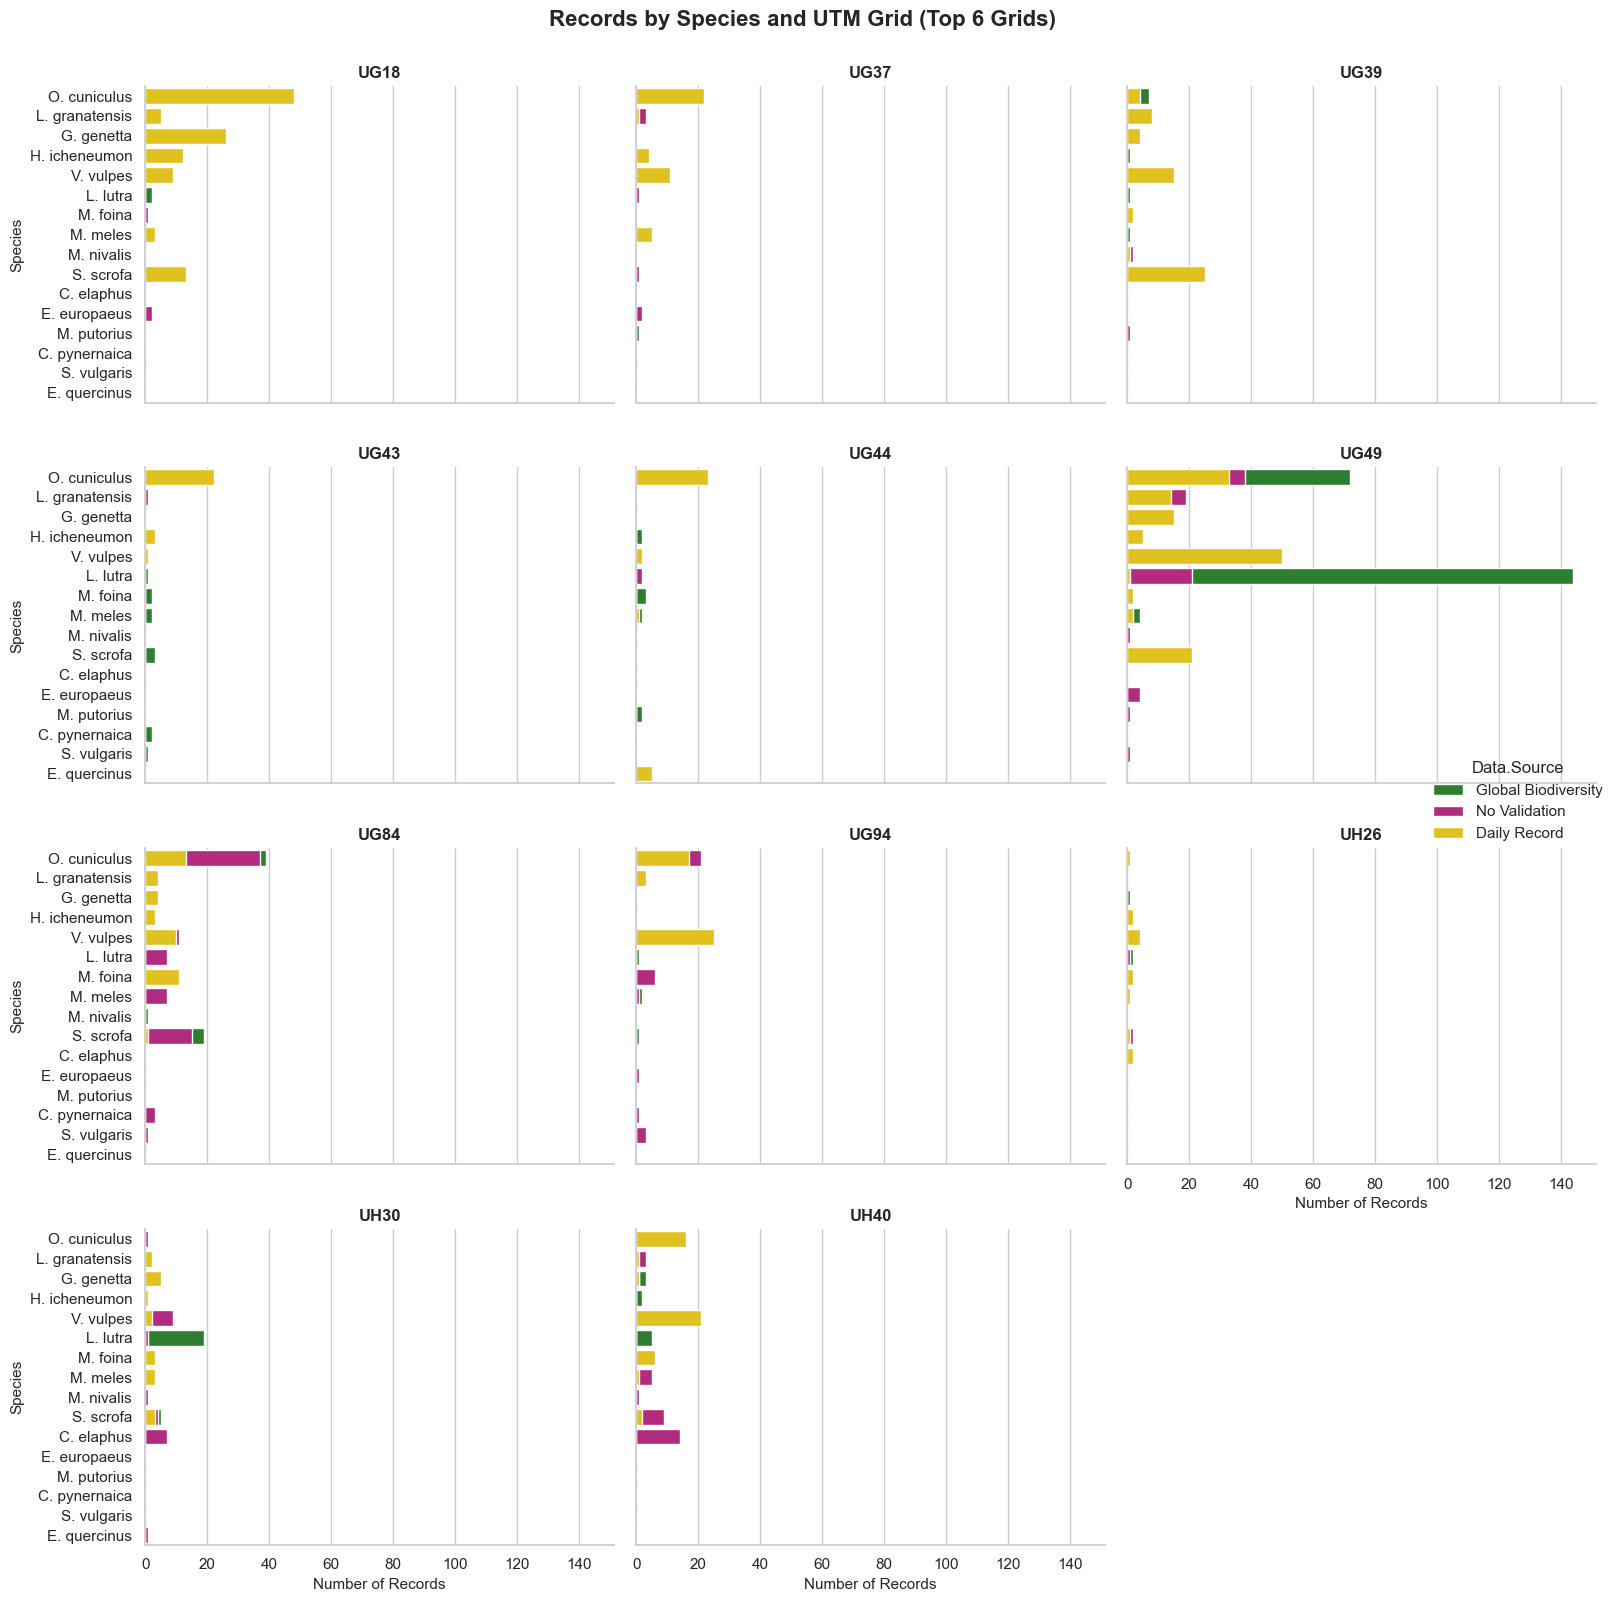

✓ Faceted plot saved to img/records_by_species_grid.png


In [ ]:
# Filter for analysis (exclude sequences for clearer visualization)
df_filtered = df[df['Data.Source'] != 'Sequences Record']

# Get top 6 grids by total records
top_grids = df_filtered.groupby('Grid')['Records'].sum().nlargest(12).index
df_top = df_filtered[df_filtered['Grid'].isin(top_grids)]

# Create faceted plot
g = sns.catplot(
    data=df_top,
    x='Records', y='Species.Name', hue='Data.Source',
    col='Grid', col_wrap=3,
    kind='bar', height=4, aspect=1.2,
    palette=palette,
    dodge=False
)

g.set_titles("{col_name}", fontsize=12, fontweight='bold')
g.set_axis_labels("Number of Records", "Species", fontsize=11)
g.figure.suptitle("Records by Species and UTM Grid (Top 6 Grids)", 
                 fontsize=16, fontweight='bold', y=1.00)

plt.tight_layout()
plt.savefig(os.path.join(IMG_DIR, 'records_by_species_grid.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Faceted plot saved to img/records_by_species_grid.png")

## 12. Grid Analysis for Data Source

In [ ]:
# NEGATIVE BINOMIAL MIXED MODELS
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Supongamos que tienes el DataFrame data_long1
data_long1 = pd.DataFrame(df_filtered)


# Variables: Records (respuesta), Platform (factor), spp y Grid (efectos aleatorios)

# Modelo completo con Platform
model1 = smf.mixedlm("Records ~Q'Data.Source'", data_long1, groups=data_long1["spp"],
                     re_formula="~Grid").fit(method='lbfgs')

print(model1.summary())


C:\Users\JoseAntonio.Blanco\AppData\Local\Temp\ipykernel_17856\3028643272.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data_long1, x='Data.Source', y='log_records', inner='box', palette='Set2')


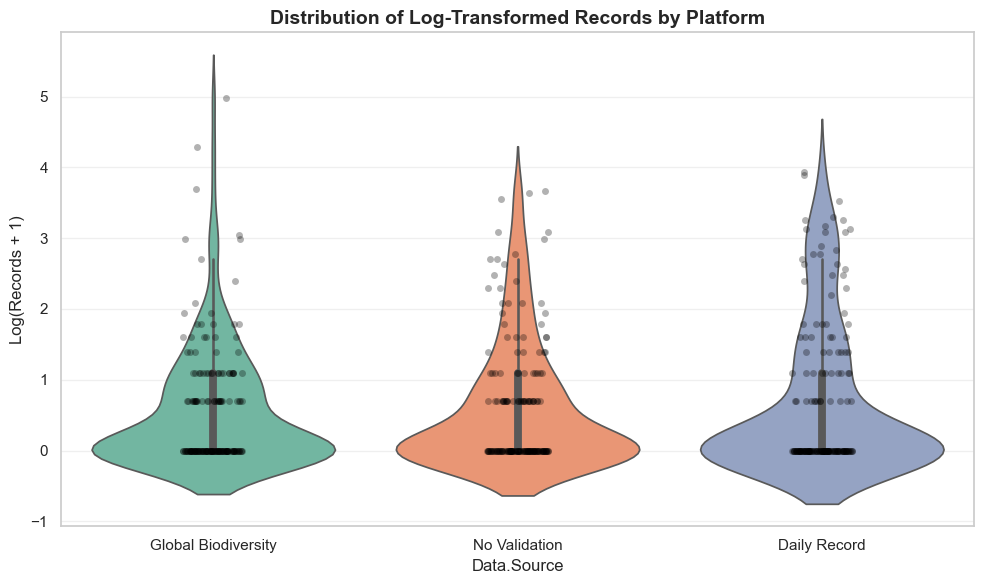

✓ Violin plot saved to img/violin_log_records_platform.png


In [ ]:


# Log-transform Records (avoid log(0) by adding 1)
data_long1['log_records'] = np.log1p(data_long1['Records'])

# Violin plot by Platform
plt.figure(figsize=(10, 6))
sns.violinplot(data=data_long1, x='Data.Source', y='log_records', inner='box', palette='Set2')
sns.stripplot(data=data_long1, x='Data.Source', y='log_records', color='black', alpha=0.3, jitter=True)

plt.title('Distribution of Log-Transformed Records by Platform', fontsize=14, fontweight='bold')
plt.xlabel('Data.Source', fontsize=12)
plt.ylabel('Log(Records + 1)', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(IMG_DIR, 'violin_log_records_platform.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Violin plot saved to img/violin_log_records_platform.png")


## 13. Summary Repport

In [ ]:
# Summary statistics and key results
print("\n--- SUMMARY OF KEY RESULTS ---\n")

print(f"Total unique species: {df['Species.Name'].nunique()}")
print(f"Total UTM grids sampled: {df['Grid'].nunique()}")
print(f"Total records: {df['Records'].sum():.0f}")
print(f"Camera trap locations: {len(cameras)}")
print(f"GBIF occurrences: {len(gbif_clean)}")

# Species richness by data source
species_by_source = df.groupby('Data.Source')['Species.Name'].nunique().reset_index()
print("\nSpecies richness by data source:")
print(species_by_source)

# Pearson correlation between daily and sequence records
if 'Daily_Sum' in df_correlation_all.columns and 'Sequences_Sum' in df_correlation_all .columns:
    corr_value = df_correlation_all[['Daily_Sum', 'Sequences_Sum']].corr(method='pearson').iloc[0, 1]
    print(f"\nPearson correlation (Daily vs Sequences): {corr_value:.3f}")

# Top 5 grids by total records
top_grids = df.groupby('Grid')['Records'].sum().nlargest(5)
print("\nTop 5 UTM grids by total records:")
print(top_grids)

print("\n--- END OF SUMMARY ---\n")


--- SUMMARY OF KEY RESULTS ---

Total unique species: 16
Total UTM grids sampled: 11
Total records: 2734
Camera trap locations: 57
GBIF occurrences: 1235

Species richness by data source:
           Data.Source  Species.Name
0         Daily Record            16
1  Global Biodiversity            16
2        No Validation            16
3     Sequences Record            16

Pearson correlation (Daily vs Sequences): 0.992

Top 5 UTM grids by total records:
Grid
UG49    698
UG18    392
UG84    261
UG44    254
UG39    219
Name: Records, dtype: int64

--- END OF SUMMARY ---

